In [2]:
from spatialomicstoolkit.StDatareader import StDatareader

In [ ]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072124" 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import voyagerpy as vp
from leidenalg import ModularityVertexPartition
import geopandas as gpd
from collections import OrderedDict
from scipy.sparse import csr_matrix

import zarr

In [123]:
adata = sc.read_10x_h5("/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp/cell_feature_matrix.h5")

In [124]:
# Function to open a Zarr file
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path))
    return zarr.group(store=store)
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp/cells.zarr.zip"
root = open_zarr(path)
column_names = dict(root['cell_summary'].attrs.items())['column_names']
def build_obs(andata,root,column_names):
    for i in range(len(column_names)):
        andata.obs[str(column_names[i])] = np.array(root["cell_summary"])[:,i]
    spatial = andata.obs[["cell_centroid_x", "cell_centroid_y"]]
    adata.obsm["spatial"] = spatial.values
    return andata
andata = build_obs(adata,root,column_names)
andata.var_names_make_unique()
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
# andata.uns['spatial']['img'] = andata.uns['spatial'][self.dataset_key].pop("images")
# andata.uns['spatial']['scale'] = andata.uns['spatial'][self.dataset_key].pop("scalefactors")
# andata.uns['spatial']['metadata'] = andata.uns['spatial'][self.dataset_key].pop("metadata")
# andata.uns['spatial'].pop(self.dataset_key)
is_mt = andata.var_names.str.startswith('mt')
vp.utils.add_per_cell_qcmetrics(andata, subsets={'mito': is_mt})
sc.pp.subsample(andata, n_obs=1_000)
sc.pp.filter_cells(andata, min_counts=10)
sc.pp.filter_cells(andata, min_genes=10)
andata.uns = {"spatial":{"scale":1}}
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
scale = 1
visium_spots = gpd.GeoSeries.from_xy(andata.obsm['spatial'][:,0], andata.obsm['spatial'][:,1]).scale(scale, scale, origin=(0, 0))
_ = vp.spatial.set_geometry(andata, geom="spot_poly", values=visium_spots)
andata.layers['counts'] = andata.X.copy()
# Log-normalize the adata.X matrix
vp.utils.log_norm_counts(andata, inplace=True)
andata.layers['logcounts'] = andata.X.copy()
andata.obs['var'] = np.var(andata.X.todense(), axis=1)
gene_var = vp.utils.model_gene_var(andata.layers['logcounts'], gene_names = andata.var_names)
hvgs = vp.utils.get_top_hvgs(gene_var)
andata.var['highly_variable'] = False
andata.var.loc[hvgs, 'highly_variable'] = True
andata.X = vp.utils.scale(andata.X, center=True)
sc.tl.pca(andata, use_highly_variable=True, n_comps=9, random_state=1337)

In [125]:
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'spatial', 'config', 'pca'
    obsm: 'spatial', 'geometry', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'logcounts'

<Axes: xlabel='PC', ylabel='Variance explained (%)'>

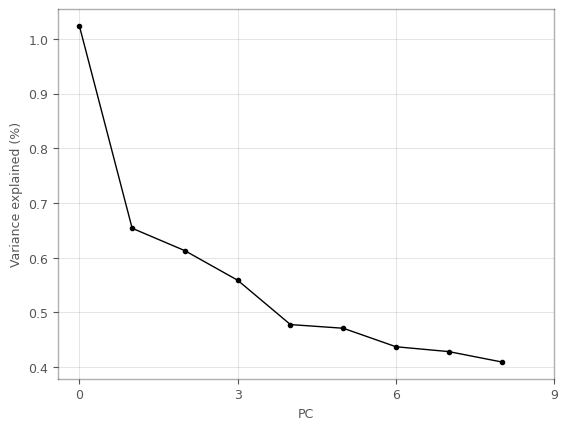

In [95]:
vp.plt.elbow_plot(andata, ndims=9)

In [126]:
sc.tl.pca(andata, use_highly_variable=True, n_comps=9, random_state=1337)
andata.X = andata.layers['logcounts'].copy()
sc.pp.neighbors(
            andata,
            n_pcs=9,
            use_rep='X_pca',
            method='gauss',
            n_neighbors=45
        )

In [127]:
sc.tl.leiden(
            andata,
            random_state=1337,
            resolution=None,
            key_added='cluster',
            partition_type=ModularityVertexPartition
        ) 

In [128]:
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'geometry', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [129]:
markers = vp.utils.find_markers(andata, hvg = True)
andata.var['symbol'] = andata.var['gene_ids'].values
marker_genes = [
    marker.sort_values(by='p.value').iloc[0].name
    for _, marker in sorted(markers.items())]

marker_genes_symbols = andata.var.loc[marker_genes, "symbol"].tolist()
andata.var.loc[marker_genes, ["symbol"]]  
andata.uns["marker_genes"] = marker_genes

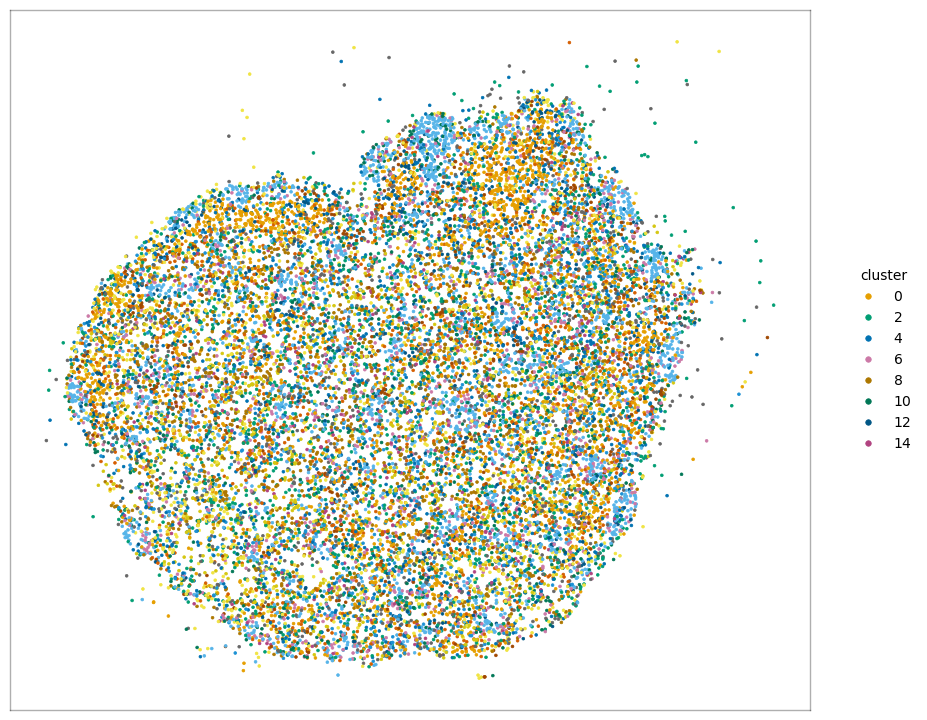

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
vp.plt.plot_spatial_feature(andata, features = 'cluster', color = 'cluster',ncol = 1,image_kwargs=None,_ax  = axs)
axs.set_xticks([])
axs.set_yticks([])
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

In [130]:
from scipy.sparse import csr_matrix
sc.pp.neighbors(
            andata,
            n_neighbors=45,
            n_pcs=9,
            use_rep='X_pca',
            knn=True,
            random_state=1337,
            method='gauss', # one of umap, gauss, rapids
            metric='euclidean', # many metrics available,
            key_added='knn')
dist = andata.obsp['knn_distances'].copy()
dist.data = 1 / dist.data

# row normalize the matrix, this makes the matrix dense.
dist /= dist.sum(axis=1)

# convert dist back to sparse matrix
andata.obsp["knn_weights"] = csr_matrix(dist)

del dist
knn_graph = "knn_weights"

andata.obsp["knn_connectivities"] = (andata.obsp[knn_graph] > 0).astype(int)
vp.spatial.set_default_graph(andata, knn_graph)
vp.spatial.to_spatial_weights(andata, graph_name=knn_graph)

qc_features = ["sum", "detected", "subsets_mito_percent"]
morans = vp.spatial.moran(andata, qc_features, graph_name=knn_graph)
andata.uns['spatial']['moran'][knn_graph].loc[qc_features, ["I"]]


vp.spatial.compute_spatial_lag(
    andata,
    qc_features,
    graph_name=knn_graph,
    inplace=True
)
vp.spatial.local_moran(andata, qc_features, graph_name=knn_graph)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/esda/moran.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/esda/moran.py:238: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/esda/moran.py:202: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy


AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'geometry', 'X_pca', 'local_moran'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [131]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"

In [132]:
andata.X = andata.layers['counts']

In [133]:
del andata.layers
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'geometry', 'X_pca', 'local_moran'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [103]:
import scipy
adata.obsp['distances']

<994x994 sparse matrix of type '<class 'numpy.float32'>'
	with 43736 stored elements in Compressed Sparse Row format>

In [104]:
adata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'geometry', 'X_pca', 'local_moran'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [105]:
[keys for keys in andata.obsp.keys()]

['distances',
 'connectivities',
 'knn_distances',
 'knn_connectivities',
 'knn_weights']

In [106]:
# import scipy.sparse
# for key in andata.obsp.keys():
#     matrix = adata.obsp[key]
#     if isinstance(matrix, scipy.sparse.spmatrix):
#         adata.obsp[key] = np.array(adata.obsp[key].todense())
# for key in andata.obsm.keys():
#     matrix = adata.obsm[key]
#     if isinstance(matrix, scipy.sparse.spmatrix):
#         adata.obsm[key] = np.array(adata.obsm[key].todense())
# for key in andata.uns.keys():
#     matrix = adata.uns[key]
#     if isinstance(matrix, scipy.sparse.spmatrix):
#         adata.uns[key] = np.array(adata.uns[key].todense()) 

In [134]:
import scipy
keys =[keys for keys in andata.obsp.keys()]
for key in keys:
    matrix = adata.obsp[key]
    if isinstance(matrix, scipy.sparse.spmatrix):
        adata.obsp[key] = np.array(adata.obsp[key].todense())
    if isinstance(matrix, OrderedDict):
        adata.obsp[key] = dict(adata.obsp[key]) 
        # adata.obsp.pop(key)
keys = [keys for keys in andata.obsm.keys()]
for key in keys:
    matrix = adata.obsm[key]
    if isinstance(matrix, scipy.sparse.spmatrix):
        adata.obsm[key] = np.array(adata.obsm[key].todense())
    if isinstance(matrix, OrderedDict):
        adata.obsm[key] = dict(adata.obsm[key]) 
        # adata.obsm.pop(key)
keys = [keys for keys in andata.uns.keys()]
for key in keys:
    matrix = adata.uns[key]
    if isinstance(matrix, scipy.sparse.spmatrix):
        adata.uns[key] = np.array(adata.uns[key].todense()) 
        #adata.uns.pop(key)
    if isinstance(matrix, OrderedDict):
        adata.uns[key] = dict(adata.uns[key]) 

In [135]:
df =  andata.obsm['geometry']
del andata.obsm['geometry'] 

In [141]:
andata.uns['spatial']['knn_weights']

In [116]:
del adata.uns['spatial']['knn_weights']

In [120]:
isinstance(adata.uns['config'], OrderedDict)

True

In [144]:
del adata.uns['config']

In [145]:
andata.write(os.path.join(pathout, 'test.h5ad'))

In [16]:
import pickle

In [24]:
import geopandas as gpd

In [32]:
andata.obsm['geometry'].to_parquet(path = os.path.join(pathout, 'test.parquet'), compression="snappy")

In [21]:
df = andata.obsm['geometry']
df['spot_poly']

abilabjl-1     POINT (3928.752 549.319)
oglehjhd-1    POINT (6211.282 4537.530)
gofdempf-1    POINT (2627.402 3175.134)
bgjijmgd-1    POINT (5141.771 1169.776)
bjekalhb-1    POINT (6006.664 1828.360)
                        ...            
enpoedmh-1    POINT (4661.501 4195.877)
cnfcpjim-1    POINT (7132.624 4844.664)
bopkjddg-1    POINT (5491.277 2485.776)
hjdbjihe-1    POINT (1165.370 3827.994)
doonplbk-1    POINT (5700.152 3493.865)
Name: spot_poly, Length: 994, dtype: geometry

In [11]:
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'geometry', 'X_pca', 'local_moran'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [34]:
del andata.obsm['geometry']
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'X_pca', 'local_moran'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [47]:
del andata.obsp
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'X_pca', 'local_moran'
    varm: 'PCs'
    layers: 'counts', 'logcounts'

In [ ]:
for key in andata.obsp.keys():
    matrix = adata.obsp[key]
    if isinstance(matrix, scipy.sparse.spmatrix):
        scipy.sparse.save_npz(f'{key}.npz', matrix)
    else:
        np.save(f'{key}.npy', matrix)

In [51]:
andata.obsp['distances'].todense()

KeyError: 'distances'

In [39]:
andata.obsp['knn_weights'].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.02040868, 0.        ,
         0.        ],
        [0.02194517, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)

In [12]:
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    obsm: 'spatial', 'geometry', 'X_pca', 'local_moran'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [17]:
del andata.layers
del andata.obsp
del andata.obsm
del andata.uns
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    uns: 'spatial', 'config', 'pca', 'neighbors', 'leiden', 'marker_genes', 'knn'
    varm: 'PCs'

In [19]:
del andata.uns

In [20]:
andata

AnnData object with n_obs × n_vars = 994 × 4624
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'n_counts', 'n_genes', 'var', 'cluster', 'lagged_sum', 'lagged_detected', 'lagged_subsets_mito_percent'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'symbol'
    varm: 'PCs'

In [21]:
andata.write_zarr(os.path.join(pathout, 'test.zarr'))

In [53]:
andata.write(os.path.join(pathout, 'test.h5ad'))

IORegistryError: No method registered for writing <class 'libpysal.weights.weights.W'> into <class 'h5py._hl.group.Group'>

Above error raised while writing key 'knn_weights' of <class 'h5py._hl.group.Group'> to /

In [35]:
outPath =  "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
andata.write(os.path.join(outPath, "andata_xenium_072124.h5ad"))

IORegistryError: No method registered for writing <class 'libpysal.weights.weights.W'> into <class 'h5py._hl.group.Group'>

Above error raised while writing key 'knn_weights' of <class 'h5py._hl.group.Group'> to /

In [18]:
if andata.obsm['geometry']:
    df = andata.obsm['geometry']
    with open(os.path.join(pathout, 'test.pkl'), 'wb') as buff:
        pickle.dump({'geometry':df}, buff)


ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

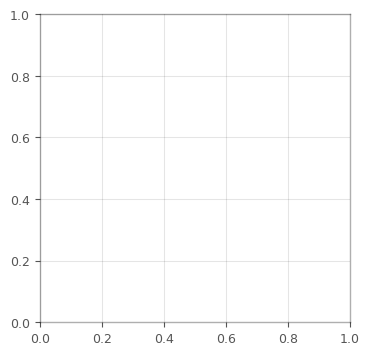

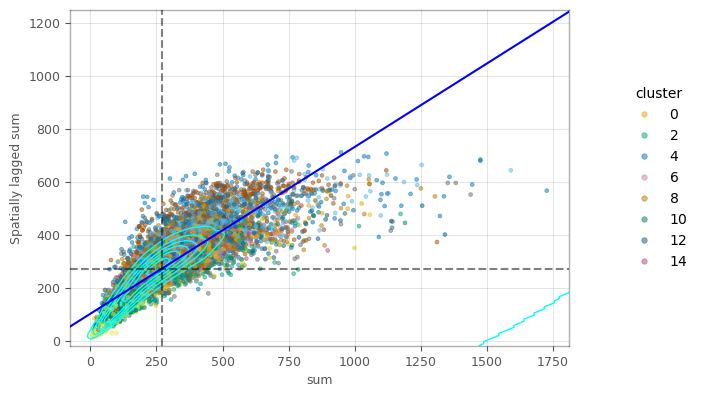

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
ax = vp.plt.moran_plot(andata, feature='sum', color_by='cluster', alpha=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

In [21]:
andata.uns["marker_genes"] 

['CD3E',
 'MS4A1',
 'PEG10',
 'XBP1',
 'LAMP3',
 'GZMB',
 'RC3H1',
 'CCN1',
 'TREM1',
 'ITGAX',
 'GPRASP1',
 'TLK1',
 'PLVAP',
 'CLEC4M',
 'WWP1']

In [19]:
marker_genes = andata.uns["marker_genes"] 
vp.plt.plot_expression(andata,marker_genes[:4],groupby='cluster',show_symbol=True,layer='logcounts',figsize=(5, 4), scatter_points=False) 
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

KeyError: "None of [Index(['A2ML1', 'AAMP', 'AAR2', 'AARSD1', 'ABAT', 'ABCA1', 'ABCA3', 'ABCA4',\n       'ABCB1', 'ABCB4',\n       ...\n       'ZPR1', 'ZSCAN1', 'ZSCAN12', 'ZSCAN16', 'ZSCAN20', 'ZSCAN26', 'ZSWIM6',\n       'ZUP1', 'ZYG11B', 'ZYX'],\n      dtype='object', length=4624)] are in the [columns]"

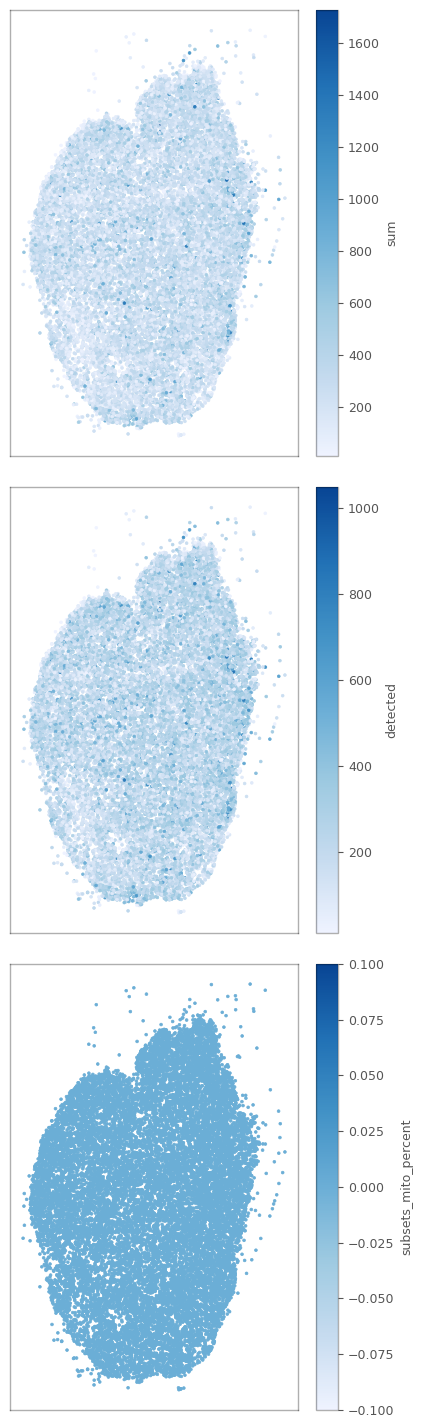

In [22]:
qc_features = ["sum", "detected", "subsets_mito_percent"]
def rm_xy(ax):
    ax.set_xticks([])
    ax.set_yticks([])
fig, axs = plt.subplots(3, 1, figsize=(6, 20))
axs = axs.ravel()
vp.plt.plot_spatial_feature(
    andata,
    features = qc_features[0],
    ncol = 1,
    image_kwargs=None,
    _ax  = axs[0])

vp.plt.plot_spatial_feature(
    andata,
    features = qc_features[1],
    ncol = 1,
    image_kwargs=None,
    _ax  = axs[1])

vp.plt.plot_spatial_feature(
    andata,
    features = qc_features[2],
        ncol = 1,
    image_kwargs=None,
    _ax  = axs[2])

fig.tight_layout()
rm_xy(axs[0])
rm_xy(axs[1])
rm_xy(axs[2])

plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)